In [21]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from BaselineRemoval import BaselineRemoval
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from torch.utils.data import TensorDataset
import torch
from torch import nn
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from torch.utils.data import TensorDataset


In [22]:
DATALABEL = ['ear lobe','inner arm','thumb nail','median cubital vein']
WATCH_PROB_PREDICT = False ## if you want to observe the probability of each choice
PLT = '/root/projects/ProjectAug22/CP/Diabete_detection_withRamanSpec/dataset/' ## change to the path to dataset
PLT_mac = '/Volumes/ExternalSSDForMac/AITLecture/CSforDSAIAUG22/_CP_project/DataScienceAndMLProjects/Diabete_detection_withRamanSpec/dataset'

SMOOTH = False

SEED = 25811243




## 1. ETL

In [23]:
from src import spectrumloader as spl
from src import get_torch_loader as tlg
# from src.modeltorch_template import NeuralNet,RamConv1d,RamLSTM,RamConv1d_bnmx,IntANN,IntRamLSTM,RamConv1d_mx
from src import trainResult_show as mtp

In [24]:
standard,data_all = spl.read_file('dataset/')

In [25]:
Xs,ys,_ = spl.cut_tonumpy(data_all)

In [26]:
assert len(Xs) == 4, 'DATA error'

## 2.Train test split (with same seed)

In [27]:
X_trainall,_,y_trainall,_ = spl.split_train_test(Xs,ys)
y_train0,y_train1,y_train2,y_train3 = y_trainall

## 3. EDA [here](https://github.com/AtiChetsurakul/DataScienceAndMLProjects/blob/main/Diabete_detection_withRamanSpec/datawatcher.ipynb)
- To shorten the file, eda not inculded

## 4. spectrum tranformation 
- incuding
    - Fluoresence removal
    - Correcting baseline
    - Normalization
## ORDER OF DATA ARE
>(0) ear lobe

>(1) inner arm 

>(2) thumb nail 

>(3) median cubital vein


In [28]:
X_train_VR = spl.fluoresence_removal(X_trainall)
if SMOOTH:
    X_train_VR = spl.savitzky_smooth(X_train_VR)

In [29]:
X_train0_std,X_train1_std,X_train2_std,X_train3_std,normalizer = spl.seting_normalized_fuoresence_smoothing(True,True,X_train_VR)

assert len(normalizer) == 4, 'Normalizer is not here'

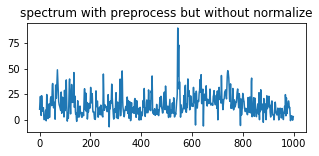

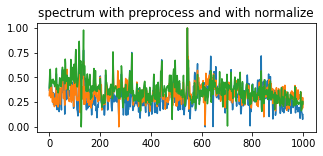

In [30]:
# Check by plot
plt.figure(figsize=(5,2))
plt.plot(X_train_VR[0][0])
plt.title('spectrum with preprocess but without normalize')
plt.show()
plt.figure(figsize=(5,2))
plt.title('spectrum with preprocess and with normalize')
plt.plot(X_train1_std[0])
plt.plot(X_train1_std[7])
plt.plot(X_train1_std[2])

plt.show()

## 5. apply data to pytorch

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [32]:
ds_earloop = TensorDataset(torch.FloatTensor(X_train0_std),torch.LongTensor(y_train0))
ds_inarm = TensorDataset(torch.FloatTensor(X_train1_std),torch.LongTensor(y_train1))
ds_thumbnail = TensorDataset(torch.FloatTensor(X_train2_std),torch.LongTensor(y_train2))
ds_vain = TensorDataset(torch.FloatTensor(X_train3_std),torch.LongTensor(y_train3))



In [33]:
train_size = 12
val_size = 4
batch_size=12
valbatch_size=4
train_loader_all,val_loader_all = tlg.shuffleloadertorch(ds_earloop,ds_inarm,ds_thumbnail,ds_vain,SEED,train_size,val_size,batch_size,valbatch_size)

## 6. modeling
- ### 6.simple
    - ### ANN
# Template to Run ANN model
- ### to use change the model name and try

## Test ANN

In [34]:
class IntANN(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, num_classes):
        super().__init__()  #super(Model, self)
        self.fc1 = nn.Linear(input_size, hidden_size) 
        #add non-linearity; recall ReLU is max(input, 0) 
        self.snm = nn.Softmax(dim=1)
        self.do1 = nn.Dropout(p=.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size2) 
        self.fc3 = nn.Linear(hidden_size2, num_classes) 
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.snm(out)
        out = self.do1(out)
        #
        out = self.fc2(out)
        out = self.snm(out)
        out = self.do1(out)
        #
        out = self.fc3(out)
        return out


In [35]:
# EXAMPLE model_for_vain = NeuralNet(1000, 14, 2).to(device) 

model_for_earloop = IntANN(1000, 28, 14, 2).to(device)
model_for_inarm = IntANN(1000, 28, 14, 2).to(device)
model_for_thumbnail = IntANN(1000, 28, 14, 2).to(device)
model_for_vain = IntANN(1000, 28, 14, 2).to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_for_vain.parameters(), lr=0.0001)  

annsim_models = [model_for_earloop,model_for_inarm,model_for_thumbnail,model_for_vain]
annsim_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
annsim_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [36]:
annsim_models[0]

IntANN(
  (fc1): Linear(in_features=1000, out_features=28, bias=True)
  (snm): Softmax(dim=1)
  (do1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=28, out_features=14, bias=True)
  (fc3): Linear(in_features=14, out_features=2, bias=True)
)

In [37]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000
train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []
for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(annsim_models,annsim_criterions,annsim_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            model.train()

            spec = spec.to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 20 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 49 == 0:
            with torch.no_grad():
                model.eval()
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')

    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [5000/5000], Step [1/1.0], Loss: 0.5530    ++++++Validation++++++  Loss: 0.86 - Acc: 25.00 
 END OF MODEL for ear lobe with val acc = 25.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.6070    ++++++Validation++++++  Loss: 0.77 - Acc: 25.00 
 END OF MODEL for inner arm with val acc = 25.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.5669    ++++++Validation++++++  Loss: 0.65 - Acc: 75.00      ++++++Validation++++++  Loss: 0.69 - Acc: 100.00     ++++++Validation++++++  Loss: 0.68 - Acc: 100.00 
 END OF MODEL for thumb nail with val acc = 75.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.6191    ++++++Validation++++++  Loss: 1.10 - Acc: 0.00 
 END OF MODEL for median cubital vein with val acc = 0.0


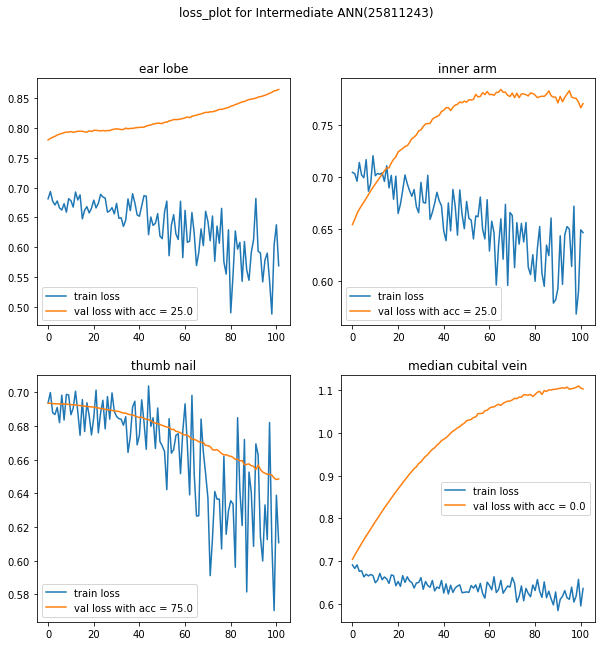

In [38]:
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'Intermediate ANN(25811243)')


In [39]:
standard,data_all = spl.read_file('dataset/')
Xs,ys,_ = spl.cut_tonumpy(data_all)
assert len(Xs) == 4, 'DATA error'

_,X_testall,_,y_testall = spl.split_train_test(Xs,ys)
X_test_VR = spl.fluoresence_removal(X_testall)
X_test0_std,X_test1_std,X_test2_std,X_test3_std,normalizer2 = spl.seting_normalized_fuoresence_smoothing(True,True,X_test_VR)

assert len(normalizer2) == 4, 'Normalizer is not here'

y_test0,y_test1,y_test2,y_test3 = y_testall

ds_test_earloop = TensorDataset(torch.FloatTensor(X_test0_std),torch.LongTensor(y_test0))
ds_test_inarm = TensorDataset(torch.FloatTensor(X_test1_std),torch.LongTensor(y_test1))
ds_test_thumbnail = TensorDataset(torch.FloatTensor(X_test2_std),torch.LongTensor(y_test2))
ds_test_vain = TensorDataset(torch.FloatTensor(X_test3_std),torch.LongTensor(y_test3))
batch_size =4 

test_loader0 = torch.utils.data.DataLoader(dataset=ds_test_earloop,batch_size=batch_size,shuffle=True)
test_loader1 = torch.utils.data.DataLoader(dataset=ds_test_inarm,batch_size=batch_size,shuffle=True)
test_loader2 = torch.utils.data.DataLoader(dataset=ds_test_thumbnail,batch_size=batch_size,shuffle=True)
test_loader3 = torch.utils.data.DataLoader(dataset=ds_test_vain,batch_size=batch_size,shuffle=True)


test_loader_all = [test_loader0,test_loader1,test_loader2,test_loader3]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
    for each_loc_test, each_loc_model in zip(test_loader_all,annsim_models):
        correct = 0
        for i, (spec, y) in enumerate(each_loc_test):  

            spec = spec.to(device)
            y_test = y.to(device)

            y_hat = each_loc_model(spec)
            predicted = torch.max(y_hat,1)[1]
            correct += (predicted == y_test).sum()
        print(f'Test accuracy: {correct.item()}/{len(y_test0)} = {correct.item()*100/(len(y_test0)):7.3f}%')

# if SMOOTH:
#     X_test_VR = spl.savitzky_smooth(X_test_VR)

Test accuracy: 4/4 = 100.000%
Test accuracy: 4/4 = 100.000%
Test accuracy: 1/4 =  25.000%
Test accuracy: 3/4 =  75.000%


- ### 6.simple
    - ### CNN
# Template FOR test your CNN

In [90]:
'''ADD YOUR MODEL HERE'''
class Conv1D_LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size=50,linear_hidden=14, out_size=2):
        super().__init__()
        self.conv1d   = nn.Conv1d(input_size, hidden_size, kernel_size = 3)
        self.linear1 = nn.Linear(49900, linear_hidden) #taking the last hidden state
        self.linear2 = nn.Linear(linear_hidden, out_size)
        
    def forward(self, seq):
        #seq shape: (10, 1, 1000)
        out = self.conv1d(seq)
        #out shape: (10, 50, 998)
        out = out.reshape(seq.size(0), -1)
        # print(out.shape)
        out = self.linear1(out)
        out = self.linear2(out)
        return out

#raise(NotImplementedError)


In [91]:
# EXAMPLE modelcnn_for_earloop = RamConv1d().to(device)

modelcnn_for_earloop = Conv1D_LSTM().to(device)
modelcnn_for_inarm = Conv1D_LSTM().to(device)
modelcnn_for_thumbnail = Conv1D_LSTM().to(device)
modelcnn_for_vain = Conv1D_LSTM().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(modelcnn_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(modelcnn_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(modelcnn_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(modelcnn_for_vain.parameters(), lr=0.0001)  

cnnsim_models = [modelcnn_for_earloop,modelcnn_for_inarm,modelcnn_for_thumbnail,modelcnn_for_vain]
cnnsim_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
cnnsim_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [92]:
cnnsim_models[0]

Conv1D_LSTM(
  (conv1d): Conv1d(1, 50, kernel_size=(3,), stride=(1,))
  (linear1): Linear(in_features=49900, out_features=14, bias=True)
  (linear2): Linear(in_features=14, out_features=2, bias=True)
)

In [93]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(cnnsim_models,cnnsim_criterions,cnnsim_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 20 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 49 == 0:
            with torch.no_grad():
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [5000/5000], Step [1/1.0], Loss: 0.0000    ++++++Validation++++++  Loss: 4.03 - Acc: 50.00 
 END OF MODEL for ear lobe with val acc = 50.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0001    ++++++Validation++++++  Loss: 1.22 - Acc: 75.00     ++++++Validation++++++  Loss: 0.89 - Acc: 75.00     ++++++Validation++++++  Loss: 1.14 - Acc: 75.00 
 END OF MODEL for inner arm with val acc = 75.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0001    ++++++Validation++++++  Loss: 0.60 - Acc: 75.00     ++++++Validation++++++  Loss: 0.59 - Acc: 75.00 
 END OF MODEL for thumb nail with val acc = 75.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0000    ++++++Validation++++++  Loss: 3.53 - Acc: 50.00 
 END OF MODEL for median cubital vein with val acc = 50.0


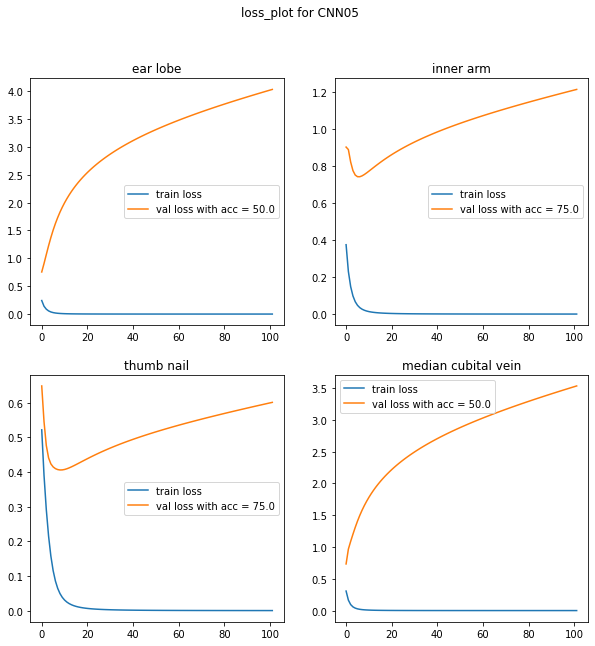

In [94]:
if WATCH_PROB_PREDICT:
    with torch.no_grad():
        print('trainpred ',cnnsim_models[-1](spec),'\n',y,'\n val\n',cnnsim_models[-1](val_spec),val_label)

mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'CNN05')

- ### 6.simple
    - RNN
- ADD YOUR Try here

In [20]:
'''ADD YOUR MODEL HERE'''

#raise(NotImplementedError)


'ADD YOUR MODEL HERE'

In [ ]:
# EXAM PLE model_RNN_for_earloop = RamLSTM().to(device)

model_RNN_for_earloop = "MODEL NAME"().to(device)
model_RNN_for_inarm = "MODEL NAME"().to(device)
model_RNN_for_thumbnail = "MODEL NAME"().to(device)
model_RNN_for_vain = "MODEL NAME"().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_RNN_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_RNN_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_RNN_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_RNN_for_vain.parameters(), lr=0.0001)  

simRNN_models = [model_RNN_for_earloop,model_RNN_for_inarm,model_RNN_for_thumbnail,model_RNN_for_vain]
simRNN_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
simRNN_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [ ]:
simRNN_models[0]

In [ ]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(simRNN_models,simRNN_criterions,simRNN_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 40 == 0:
            with torch.no_grad():
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

In [ ]:
if WATCH_PROB_PREDICT:
    with torch.no_grad():
        print('trainpred ',simRNN_models[-1](spec),'\n',y,'\n val\n',simRNN_models[-1](val_spec),val_label)
        print(criterion(simRNN_models[-1](val_spec),val_label))
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'simple_RNN')